# Introduction

Malaria Cell Classifier is a project to determine if an image is infected/uninfected. Basically, it is my first project into the wild after 2 months of learning. Pray for me ;) 

# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, SGD

from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

import copy
import time
import os

# Load Data

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [12]:
dataset = {
    "train": datasets.ImageFolder(root=os.path.join("./Data","train"),
                                  transform=transform["train"]),
    "val": datasets.ImageFolder(root=os.path.join("./Data","val"), 
                               transform=transform["val"])
}

In [13]:
dataloader = {
    "train": torch.utils.data.DataLoader(dataset=dataset["train"], batch_size=4, shuffle=True,
                                         num_workers=4),
    "val": torch.utils.data.DataLoader(dataset=dataset["val"], batch_size=4, shuffle=True,
                                      num_workers=4)
}



In [14]:
classes = dataset["train"].classes
classes

['infected', 'uninfected']

In [15]:
dataset_size = {
    "train": len(dataset["train"]),
    "val": len(dataset["val"])
}

In [16]:
dataset_size["val"]

6888

# Visualize Dataset

In [17]:
def imshow(image, title=None):
    image = image.numpy()
    image = np.transpose(image,[1,2,0])
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image,0,1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

In [18]:
image = dataset["train"][0] 

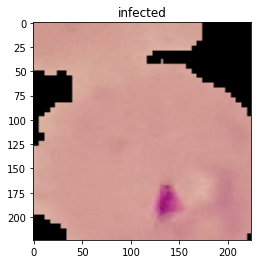

In [13]:
imshow(image[0],classes[image[1]])

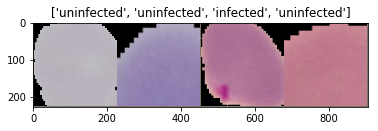

In [19]:
images, labels = next(iter(dataloader["train"]))
images = make_grid(images)
imshow(images,title=[classes[label] for label in labels ])

# Train Dataset 

In [49]:
model = models.resnet18(pretrained=True)

In [22]:
len(list(model.parameters()))

62

In [44]:
for index, params in enumerate(model.parameters()):
        params.requires_grad = True

In [23]:
num_ftrs = model.fc.in_features

In [24]:
num_ftrs

512

In [52]:
model.fc = nn.Sequential(
    nn.Linear(num_ftrs,300),
    nn.ReLU(),
    nn.Linear(300,87),
    nn.ReLU(),
    nn.Linear(87,2)
)

In [26]:
model = model.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()

In [28]:
optimizer = SGD(model.parameters(),lr=1e-4,momentum=0.9)

In [29]:
scheduler = lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)

In [96]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    start_time = time.time()
    
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(1,num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        print("-" * 10)
        
        for phase in ["train","val"]:
            running_loss = 0.0
            running_correct = 0
                
            if phase is "train":
                model.train()
                scheduler.step()
                
                for inputs, labels in dataloader[phase]:
                    optimizer.zero_grad()
                    
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(inputs)
                    
                    loss = criterion(outputs,labels)
                    loss.backward()
                    
                    _, prediction = torch.max(outputs,1)
                    optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_correct += torch.sum(prediction == labels.data).cpu().numpy()
                    
                epoch_loss = running_loss / dataset_size[phase]
                epoch_accuracy = running_correct / dataset_size[phase]
                print("{} Loss {:.6f}".format(phase, epoch_loss))
                print("{}   Acc: {:.6f}".format(phase, epoch_accuracy))
            else:
                model.eval()
                
                for inputs, labels in dataloader[phase]:
                    
                    with torch.no_grad():
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(inputs)
                        
                        loss = criterion(outputs,labels)
                        _, prediction = torch.max(outputs,1)
                        
                        running_loss += loss.item() * inputs.size(0)
                        running_correct += torch.sum(prediction == labels.data).cpu().numpy()
                
                epoch_loss = running_loss / dataset_size[phase]
                epoch_accuracy = running_correct / dataset_size[phase]
                print("{} Loss {:.6f}".format(phase, epoch_loss))
                print("{}   Acc: {:.6f}".format(phase, epoch_accuracy))
                
                if epoch_accuracy > best_acc:
                    best_acc = epoch_accuracy
                    best_model_wts = copy.deepcopy(model.state_dict())
        
    time_elapsed = time.time() - start_time
    print()
    print("Best val Acc: {:.6f}".format(best_acc))
    print("Total time elapsed {:2f}min {:2f}sec".format(time_elapsed//60,time_elapsed % 60))
    
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
best_model = train_model(model,optimizer,criterion,scheduler)

Epoch 1/25
----------
train Loss 0.297220
train   Acc: 0.875714
val Loss 0.180026
val   Acc: 0.947009
Epoch 2/25
----------
train Loss 0.296118
train   Acc: 0.873246
val Loss 0.185579
val   Acc: 0.937137
Epoch 3/25
----------
train Loss 0.293678
train   Acc: 0.875423
val Loss 0.206817
val   Acc: 0.925377
Epoch 4/25
----------
train Loss 0.298496
train   Acc: 0.872182
val Loss 0.177214
val   Acc: 0.943670
Epoch 5/25
----------
train Loss 0.297592
train   Acc: 0.874359
val Loss 0.179016
val   Acc: 0.936121
Epoch 6/25
----------
train Loss 0.291800
train   Acc: 0.874069
val Loss 0.171841
val   Acc: 0.945993
Epoch 7/25
----------
train Loss 0.289039
train   Acc: 0.878568
val Loss 0.188095
val   Acc: 0.935685
Epoch 8/25
----------
train Loss 0.288252
train   Acc: 0.876730
val Loss 0.197700
val   Acc: 0.929007
Epoch 9/25
----------
train Loss 0.293354
train   Acc: 0.875327
val Loss 0.173117
val   Acc: 0.946719
Epoch 10/25
----------
train Loss 0.295209
train   Acc: 0.873730
val Loss 0.163686

In [47]:
torch.save(model.state_dict(),"./malaria_model_weights.pth")